# Group work - Heart Disease Detection


### Importing libraries


In [4]:
%matplotlib inline
import pandas as pd
import numpy as np
import itertools
import time
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
import seaborn as sns; sns.set()
#from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier #Decision Tree algorithm
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.metrics import roc_curve, auc






from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer


import pandas as pd #data frames (for storing data)
import numpy as np #scientific computing
import itertools

#matplotlib for plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.ticker as mtick #for percentage ticks



### Importing data

In [12]:
data_initial = pd.read_csv('heart.csv')
data_initial.head().style #Call the head() function to see how the dataset looks (.style() shows all columns)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


### Feature Extraction : Creating Dummy Variable for Analysis 

In [13]:
data_dummy = pd.get_dummies(data_initial, columns=["sex","cp","restecg","slope","thal"], 
                      prefix=["sex","cp","restecg","slope","thal"]) #we add a prefix for easier identification

data_dummy.head().style

,age,trestbps,chol,fbs,thalach,exang,oldpeak,ca,target,sex_0,sex_1,cp_0,cp_1,cp_2,cp_3,restecg_0,restecg_1,restecg_2,slope_0,slope_1,slope_2,thal_0,thal_1,thal_2,thal_3
0,63,145,233,1,150,0,2.3,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0
1,37,130,250,0,187,0,3.5,0,1,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0
2,41,130,204,0,172,0,1.4,0,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0
3,56,120,236,0,178,0,0.8,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0
4,57,120,354,0,163,1,0.6,0,1,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0


In [14]:
data = data_dummy.rename(index = str, columns= {"sex_0": "sex_female" , "sex_1" : "sex_male", "cp_0" : "cp_typical angina" ,"cp_1" : 
"cp_atypical angina", "cp_2" : "cp_non-anginal pain" , "cp_3" : "cp_asymptomatic", "restecg_0" : "restecg_normal" ,"restecg_1" : "restecg_ST-T wave abnormality",
"restecg_2":"restecg_left ventricular hypertrophy","slope_0": "slope_upsloping", "slope_1" : "slope_flat" , 
"slope_2" : "slope_downsloping"  })

In [6]:
data.head().style

,age,trestbps,chol,fbs,thalach,exang,oldpeak,ca,target,sex_female,sex_male,cp_typical angina,cp_angina,cp_non-anginal pain,cp_asymptomatic,restecg_normal,restecg_ST-T wave abnormality,restecg_left ventricular hypertrophy,slope_upsloping,slope_flat,slope_downsloping,thal_0,thal_1,thal_2,thal_3
0,63,145,233,1,150,0,2.3,0,1,0,1,0,0,0,1,1,0,0,1,0,0,0,1,0,0
1,37,130,250,0,187,0,3.5,0,1,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0
2,41,130,204,0,172,0,1.4,0,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0
3,56,120,236,0,178,0,0.8,0,1,0,1,0,1,0,0,0,1,0,0,0,1,0,0,1,0
4,57,120,354,0,163,1,0.6,0,1,1,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0


## Explanatory Data Analysis


In [227]:
data.info()  #No NAs

<class 'pandas.core.frame.DataFrame'>
Index: 303 entries, 0 to 302
Data columns (total 25 columns):
age                                     303 non-null int64
trestbps                                303 non-null int64
chol                                    303 non-null int64
fbs                                     303 non-null int64
thalach                                 303 non-null int64
exang                                   303 non-null int64
oldpeak                                 303 non-null float64
ca                                      303 non-null int64
target                                  303 non-null int64
sex_female                              303 non-null uint8
sex_male                                303 non-null uint8
cp_typical angina                       303 non-null uint8
cp_angina                               303 non-null uint8
cp_non-anginal pain                     303 non-null uint8
cp_asymptomatic                         303 non-null uint8
restecg_norma

In [228]:
# Print the dimensions of the original Hitters data (322 rows x 20 columns)
print("Dimensions of original data:", data.shape)
# From herer it can be seen that the data set is big, 18207 rows and 89 columns!

Dimensions of original data: (303, 25)


In [7]:
(data['target'] == 1).sum()

165

In [8]:
(data['target'] == 0).sum()

138

### Data is not Imbalanced 

## Visualizing the data

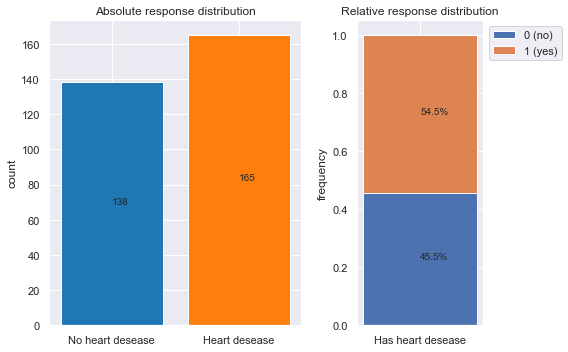

In [9]:
# plot response
keys, counts = np.unique(data.target, return_counts=True)
counts_norm = counts/counts.sum()

fig = plt.figure(figsize=(8, 5)) #specify figure size
gs = gridspec.GridSpec(1, 2, width_ratios=[2,1]) #specify relative size of left and right plot

#Absolute values
ax0 = plt.subplot(gs[0])
ax0 = plt.bar(['No heart desease', 'Heart desease'], counts, color=['#1f77b4','#ff7f0e']) #left bar plot
ax0 = plt.title('Absolute response distribution') 
ax0 = plt.ylabel('count')
ax0 = plt.text(keys[0], counts[0]/2, counts[0]) #add text box with count of non-fraudulent cases
ax0 = plt.text(keys[1], counts[1]/2, counts[1]) #add text box with count of fraudulent cases

#Normalized values
ax1 = plt.subplot(gs[1])
ax1 = plt.bar(['Has heart desease'], [counts_norm[0]], label='0 (no)')
ax1 = plt.bar(['Has heart desease'], [counts_norm[1]], bottom=counts_norm[0], label='1 (yes)')
ax1 = plt.legend(bbox_to_anchor=(1, 1))
ax1 = plt.title('Relative response distribution')
ax1 = plt.ylabel('frequency')
ax1 = plt.text(['Has heart desease'],counts_norm[0]/2, '{}%'.format((counts_norm[0]*100).round(1)))
ax1 = plt.text(['Has heart desease'],(counts_norm[1]/2)+counts_norm[0], '{}%'.format((counts_norm[1]*100).round(1)))

plt.tight_layout()
plt.show()

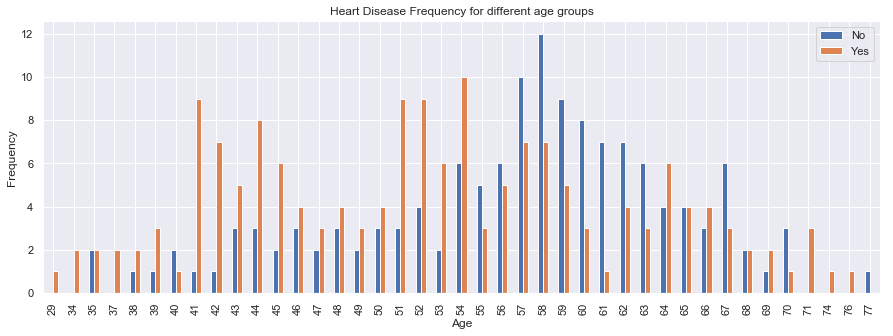

In [10]:
pd.crosstab(data.age,data.target).plot(kind="bar",figsize=(15,5),)
heart_disease = ['No' , 'Yes']
plt.title('Heart Disease Frequency for different age groups')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend(heart_disease)
plt.show()


## Data Preprocessing 

In [18]:
X, y = data.loc[:, data.columns != 'target'], data['target']

In [19]:
X.head()


,age,trestbps,chol,fbs,thalach,exang,oldpeak,ca,sex_female,sex_male,...,restecg_normal,restecg_ST-T wave abnormality,restecg_left ventricular hypertrophy,slope_upsloping,slope_flat,slope_downsloping,thal_0,thal_1,thal_2,thal_3
0,63,145,233,1,150,0,2.3,0,0,1,...,1,0,0,1,0,0,0,1,0,0
1,37,130,250,0,187,0,3.5,0,0,1,...,0,1,0,1,0,0,0,0,1,0
2,41,130,204,0,172,0,1.4,0,1,0,...,1,0,0,0,0,1,0,0,1,0
3,56,120,236,0,178,0,0.8,0,0,1,...,0,1,0,0,0,1,0,0,1,0
4,57,120,354,0,163,1,0.6,0,1,0,...,0,1,0,0,0,1,0,0,1,0


In [20]:
y.head()

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64

### Feature Scaling

In [21]:
#Normalizing the data
scaled_X = preprocessing.quantile_transform(X)

pd_scaled_X  = pd.DataFrame(scaled_X)

In [22]:
pd_scaled_X.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,0.817818,0.811311,0.428929,9.999999e-01,0.446947,1.000000e-07,0.855856,1.000000e-07,1.000000e-07,9.999999e-01,...,9.999999e-01,1.000000e-07,1.000000e-07,9.999999e-01,1.000000e-07,1.000000e-07,1.000000e-07,9.999999e-01,1.000000e-07,1.000000e-07
1,0.025025,0.505005,0.579580,1.000000e-07,0.980132,1.000000e-07,0.956954,1.000000e-07,1.000000e-07,9.999999e-01,...,1.000000e-07,9.999999e-01,1.000000e-07,9.999999e-01,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,9.999999e-01,1.000000e-07
2,0.077578,0.505005,0.197197,1.000000e-07,0.834334,1.000000e-07,0.682182,1.000000e-07,9.999999e-01,1.000000e-07,...,9.999999e-01,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,9.999999e-01,1.000000e-07,1.000000e-07,9.999999e-01,1.000000e-07
3,0.519520,0.258258,0.466967,1.000000e-07,0.910911,1.000000e-07,0.516517,1.000000e-07,1.000000e-07,9.999999e-01,...,1.000000e-07,9.999999e-01,1.000000e-07,1.000000e-07,1.000000e-07,9.999999e-01,1.000000e-07,1.000000e-07,9.999999e-01,1.000000e-07
4,0.566567,0.258258,0.980009,1.000000e-07,0.705205,9.999999e-01,0.468468,1.000000e-07,9.999999e-01,1.000000e-07,...,1.000000e-07,9.999999e-01,1.000000e-07,1.000000e-07,1.000000e-07,9.999999e-01,1.000000e-07,1.000000e-07,9.999999e-01,1.000000e-07


In [23]:
X.columns.values

array(['age', 'trestbps', 'chol', 'fbs', 'thalach', 'exang', 'oldpeak',
       'ca', 'sex_female', 'sex_male', 'cp_typical angina',
       'cp_atypical angina', 'cp_non-anginal pain', 'cp_asymptomatic',
       'restecg_normal', 'restecg_ST-T wave abnormality',
       'restecg_left ventricular hypertrophy', 'slope_upsloping',
       'slope_flat', 'slope_downsloping', 'thal_0', 'thal_1', 'thal_2',
       'thal_3'], dtype=object)

In [24]:
pd_scaled_X.columns.values

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23], dtype=int64)

In [25]:
pd_scaled_X.columns = X.columns.values #fixing the names of the fetures 

In [26]:
pd_scaled_X.columns.values

array(['age', 'trestbps', 'chol', 'fbs', 'thalach', 'exang', 'oldpeak',
       'ca', 'sex_female', 'sex_male', 'cp_typical angina',
       'cp_atypical angina', 'cp_non-anginal pain', 'cp_asymptomatic',
       'restecg_normal', 'restecg_ST-T wave abnormality',
       'restecg_left ventricular hypertrophy', 'slope_upsloping',
       'slope_flat', 'slope_downsloping', 'thal_0', 'thal_1', 'thal_2',
       'thal_3'], dtype=object)

In [27]:
pd_scaled_X.head()

,age,trestbps,chol,fbs,thalach,exang,oldpeak,ca,sex_female,sex_male,...,restecg_normal,restecg_ST-T wave abnormality,restecg_left ventricular hypertrophy,slope_upsloping,slope_flat,slope_downsloping,thal_0,thal_1,thal_2,thal_3
0,0.817818,0.811311,0.428929,9.999999e-01,0.446947,1.000000e-07,0.855856,1.000000e-07,1.000000e-07,9.999999e-01,...,9.999999e-01,1.000000e-07,1.000000e-07,9.999999e-01,1.000000e-07,1.000000e-07,1.000000e-07,9.999999e-01,1.000000e-07,1.000000e-07
1,0.025025,0.505005,0.579580,1.000000e-07,0.980132,1.000000e-07,0.956954,1.000000e-07,1.000000e-07,9.999999e-01,...,1.000000e-07,9.999999e-01,1.000000e-07,9.999999e-01,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,9.999999e-01,1.000000e-07
2,0.077578,0.505005,0.197197,1.000000e-07,0.834334,1.000000e-07,0.682182,1.000000e-07,9.999999e-01,1.000000e-07,...,9.999999e-01,1.000000e-07,1.000000e-07,1.000000e-07,1.000000e-07,9.999999e-01,1.000000e-07,1.000000e-07,9.999999e-01,1.000000e-07
3,0.519520,0.258258,0.466967,1.000000e-07,0.910911,1.000000e-07,0.516517,1.000000e-07,1.000000e-07,9.999999e-01,...,1.000000e-07,9.999999e-01,1.000000e-07,1.000000e-07,1.000000e-07,9.999999e-01,1.000000e-07,1.000000e-07,9.999999e-01,1.000000e-07
4,0.566567,0.258258,0.980009,1.000000e-07,0.705205,9.999999e-01,0.468468,1.000000e-07,9.999999e-01,1.000000e-07,...,1.000000e-07,9.999999e-01,1.000000e-07,1.000000e-07,1.000000e-07,9.999999e-01,1.000000e-07,1.000000e-07,9.999999e-01,1.000000e-07


## Data Split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100 ) #split data 70:30

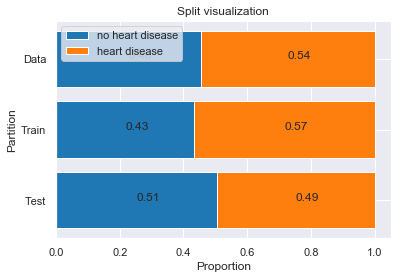

In [29]:
train_dist = y_train.value_counts() / len(y_train) #normalize absolute count values for plotting
test_dist = y_test.value_counts() / len(y_test)
data_dist = data['target'].value_counts() / len(data)

fig, ax = plt.subplots()

ax.barh(['Test','Train','Data'], [test_dist[0], train_dist[0], data_dist[0]], color='#1f77b4', label='no heart disease')
ax.barh(['Test','Train','Data'], [test_dist[1], train_dist[1], data_dist[1]], left=[test_dist[0], train_dist[0], data_dist[0]], color='#ff7f0e', label='heart disease')
ax.set_title('Split visualization')
ax.legend(loc='upper left')
plt.xlabel('Proportion')
plt.ylabel('Partition')

#plot bar values
for part, a, b in zip(['Test', 'Train','Data'], [test_dist[0], train_dist[0], data_dist[0]], [test_dist[1], train_dist[1], data_dist[1]]):
    plt.text(a/2, part, str(np.round(a, 2)))
    plt.text(b/2+a, part, str(np.round(b, 2)));

The Distribution of  heart disease to no heart disease is similar in train and test is similar to the distribution in the original data set. Hence, the split was succesful. 

Text(0.5, 1.0, 'Heat Map of Correlation Matrix')

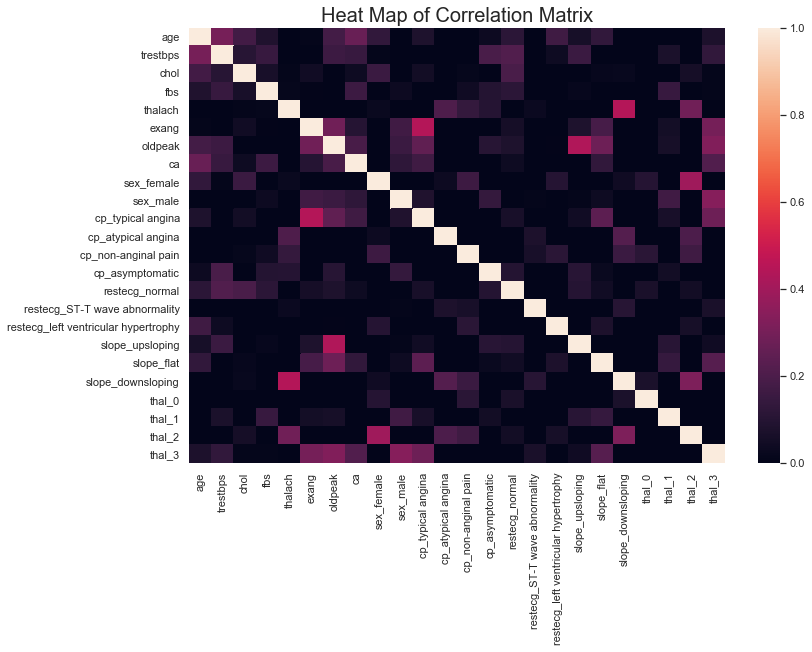

In [30]:
corr_matrix = X_train.corr()
corr_matrix_absolute = X_train.corr().abs()
plt.figure(figsize=(12,8))

sns.heatmap(corr_matrix, vmin=0, vmax=1)
plt.title('Heat Map of Correlation Matrix', fontdict = {'fontsize' : 20})



Text(0.5,1,'Heat Map of Correlation Matrix with absolute values')

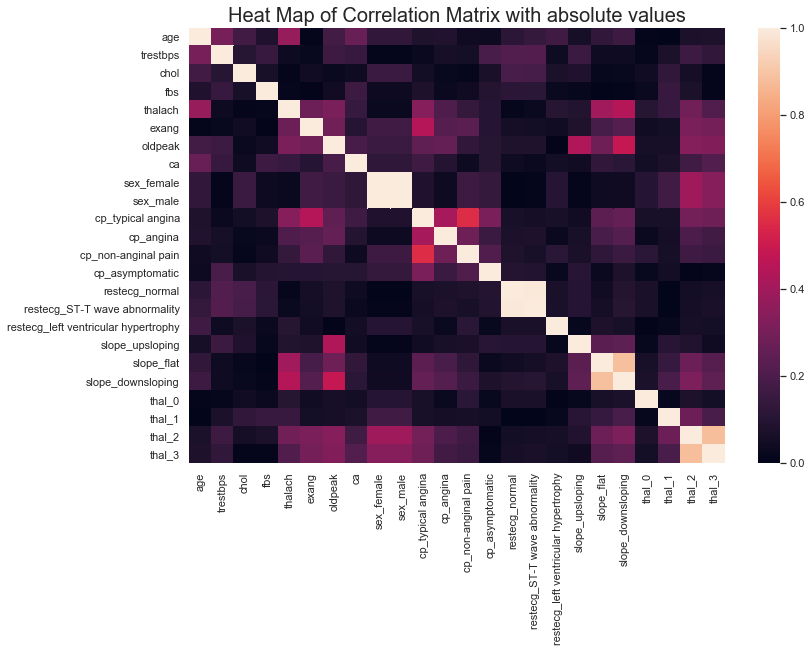

In [26]:
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix_absolute, vmin=0, vmax=1)
plt.title('Heat Map of Correlation Matrix with absolute values', fontdict = {'fontsize' : 20})


### We can clearly see that there is not much correlation between the features.

## Buliding the Model 

### Logistic Regression

In [31]:
logisticRegr = LogisticRegression()

In [32]:
logisticRegr.fit(X_train, y_train)

C:\Users\antti\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [33]:
predictions_lr = logisticRegr.predict(X_test)

In [34]:
score = logisticRegr.score(X_test, y_test)
print(score)

0.8791208791208791


###  This is the best model


In [35]:
predictions_lr

array([1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 0], dtype=int64)

In [36]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

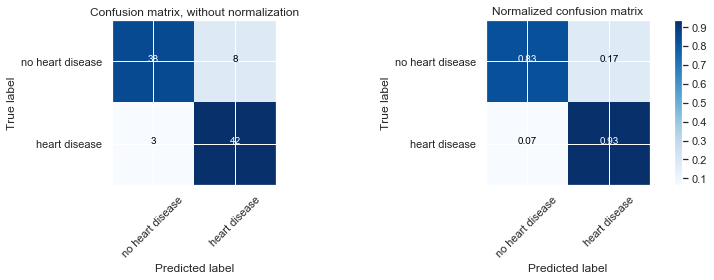

In [33]:
# Compute confusion matrix
class_names = ['no heart disease', 'heart disease']
cnf_matrix = confusion_matrix(y_test, predictions_lr)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(12, 4))
plt.subplot(121) 
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(122) 
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Using Logistic Regression on Normalized Data

In [37]:
X_train_nr, X_test_nr, y_train_nr, y_test_nr = train_test_split(pd_scaled_X, y, test_size = 0.3, random_state = 100  ) #split data 70:30

In [38]:
X_test_nr.shape

(91, 24)

In [39]:
lr_model = logisticRegr.fit(X_train_nr, y_train_nr)

C:\Users\antti\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [40]:
score = logisticRegr.score(X_test_nr, y_test_nr)
print(score)

0.8791208791208791


In [41]:
y_pred_lr_nm = lr_model.predict(X_test_nr)

### Confusion Matrix

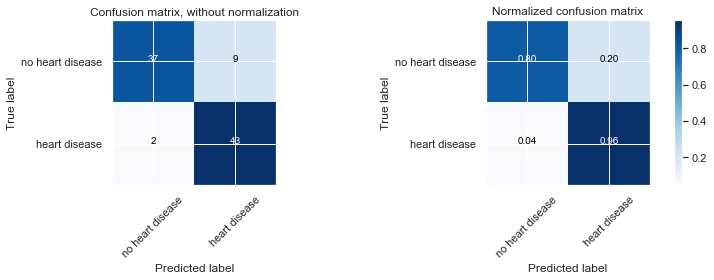

In [44]:
# Compute confusion matrix
class_names = ['no heart disease', 'heart disease']
cnf_matrix = confusion_matrix(y_test_nr, y_pred_lr_nm)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(12, 4))
plt.subplot(121) 
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(122) 
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [42]:
#Feature importance
feature_importance = lr_model.coef_[0]
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
feature_importance

array([ 0.26087078, -0.10820422, -0.62001651, -0.07292447,  0.62262872,
       -0.27888978, -0.51801082, -2.34223824,  0.78036259, -0.20872059,
       -0.82686893,  0.02844284,  0.9015566 ,  0.4685116 ,  0.11340389,
        0.40665478,  0.05158337, -0.15105339, -0.08710895,  0.8098044 ,
        0.04109905,  0.38650362,  0.85225307, -0.70821362])

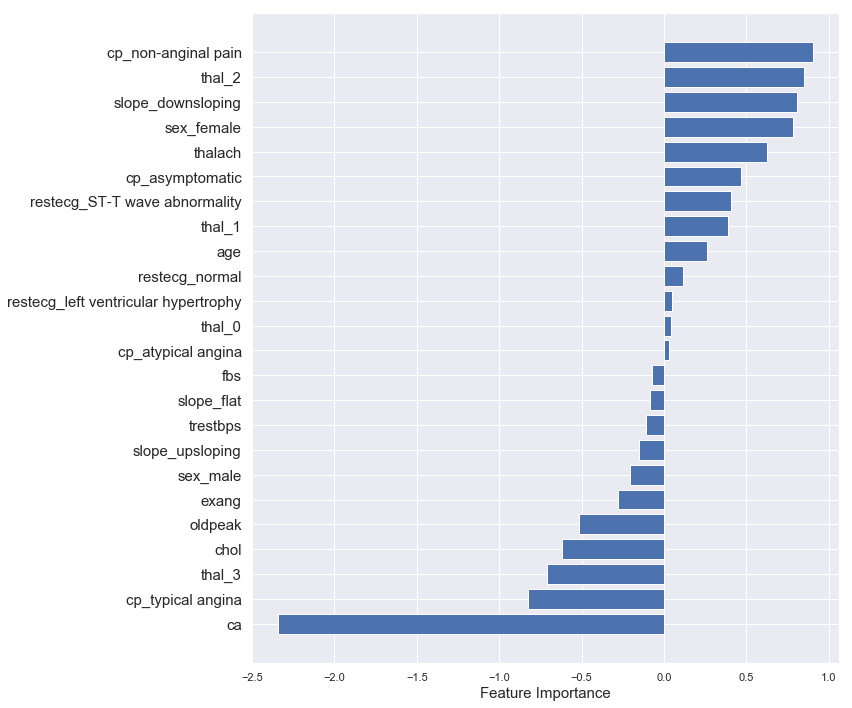

In [44]:
#Ploting the feature importance
featfig = plt.figure(figsize=(12,10))

featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=15)
featax.set_xlabel('Feature Importance',fontsize = '15')


plt.tight_layout()   
plt.show()

In [53]:
print(sum(feature_importance<-0.8))
print(sum(feature_importance>0.8))

2
3


### Using Feature Scaling is improving our Accuracy 

## Using SVM 

### Using Grid Search CV to find the best SVM parameters

In [45]:
parameter_candidates = [
  {'C': [1, 10, 100, 1000,10000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000,10000], 'gamma': [0.1,0.01,0.001, 0.0001], 'kernel': ['rbf']},
]
clf = GridSearchCV(estimator=SVC(), param_grid=parameter_candidates, n_jobs=-1)
clf.fit(X_train, y_train) 
print('Best score for data1:', clf.best_score_) 
print('Best C:',clf.best_estimator_.C) 
print('Best Kernel:',clf.best_estimator_.kernel)
print('Best Gamma:',clf.best_estimator_.gamma)

Best score for data1: 0.7830188679245284
Best C: 100
Best Kernel: linear
Best Gamma: auto


In [46]:
svm_model = SVC(kernel = 'linear', C = 100, gamma ="auto").fit(X_train, y_train)

In [47]:
svm_model.score(X_test,y_test)

0.8791208791208791

In [48]:
y_pred_svm = svm_model.predict(X_test)

### Confusion Matrix

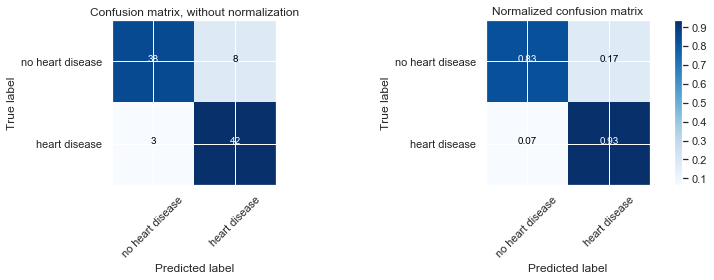

In [49]:
# Compute confusion matrix
class_names = ['no heart disease', 'heart disease']
cnf_matrix = confusion_matrix(y_test, y_pred_svm)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(12, 4))
plt.subplot(121) 
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(122) 
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### SVM on normalized data 

In [50]:
parameter_candidates = [
  {'C': [1, 10, 100, 1000,10000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000,10000], 'gamma': [0.1,0.01,0.001, 0.0001], 'kernel': ['rbf']},
]

clf_gs = GridSearchCV(estimator=SVC(), param_grid=parameter_candidates, n_jobs=-1)
clf_gs.fit(X_train_nr, y_train_nr) 
print('Best score for data1:', clf.best_score_) 
print('Best C:',clf.best_estimator_.C) 
print('Best Kernel:',clf.best_estimator_.kernel)
print('Best Gamma:',clf.best_estimator_.gamma)

Best score for data1: 0.7830188679245284
Best C: 100
Best Kernel: linear
Best Gamma: auto


In [51]:
svm_model_nr = SVC(kernel = 'linear', C = 100).fit(X_train_nr, y_train_nr)

In [52]:
svm_model_nr.score(X_test_nr,y_test_nr)

0.8241758241758241

In [53]:
y_pred_svm_nm =svm_model_nr.predict(X_test_nr)

In [54]:
weights = svm_model_nr.coef_
weights

array([[ 1.30e+00, -1.87e-01, -1.16e+00, -1.04e-13,  1.62e-01, -1.66e-01,
        -5.55e-01, -3.15e+00,  2.56e-01, -2.56e-01, -9.47e-01, -2.12e-01,
         9.39e-01,  2.21e-01, -2.08e-01,  2.08e-01, -1.48e-19, -3.35e-01,
        -2.51e-01,  5.86e-01, -1.48e-19, -5.24e-02,  9.18e-01, -8.66e-01]])

### Confusion Matrix

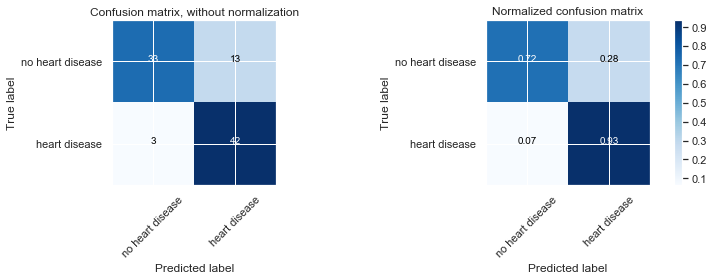

In [55]:
# Compute confusion matrix
class_names = ['no heart disease', 'heart disease']
cnf_matrix = confusion_matrix(y_test_nr, y_pred_svm_nm)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(12, 4))
plt.subplot(121) 
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(122) 
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Decision Trees 

In [56]:
#Define Decision tree classifier with some default parameters
clf_DT = DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=3, min_samples_leaf=3)

#Fit the training data 
clf_DT.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [61]:
clf_DT.score(X_test,y_test)

0.8351648351648352

In [60]:
y_pred_dt = clf_DT.predict(X_test)

### Confusion Matrix

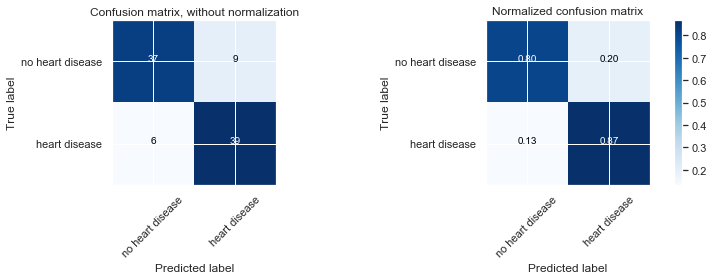

In [62]:
# Compute confusion matrix
class_names = ['no heart disease', 'heart disease']
cnf_matrix = confusion_matrix(y_test, y_pred_dt)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(12, 4))
plt.subplot(121) 
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(122) 
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Decision Trees with Normalized Data 

In [63]:
#Define Decision tree classifier with some default parameters
clf_DT_nr = DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=2, min_samples_leaf=3)

#Fit the training data 
clf_DT_nr.fit(X_train_nr, y_train_nr)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [64]:
clf_DT_nr.score(X_test_nr,y_test_nr)

0.7142857142857143

In [65]:
y_pred_dt_nm = clf_DT_nr.predict(X_test_nr)

### Feature Importance Decision Trees

In [ ]:
importances = clf_DT_nr.feature_importances__
indices = np.argsort(importances)[::-1]
feature_order = np.array([X.columns.values])
i = np.argsort(importances)[::-1]
feature_order = feature_order[:,i]

In [ ]:
plt.figure()
plt.title("Relative feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="b",  align="center")
plt.xticks(range(X.shape[1]), feature_order[0], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

In [66]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [67]:
print(y_pred_dt_nm.shape)
print(y_test_nr.shape)

(91,)
(91,)


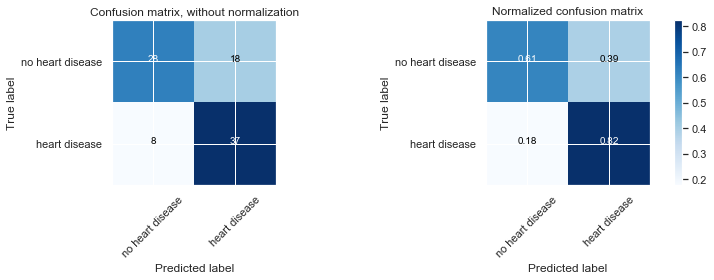

In [68]:
# Compute confusion matrix
class_names = ['no heart disease', 'heart disease']
cnf_matrix = confusion_matrix(y_test_nr, y_pred_dt_nm)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(12, 4))
plt.subplot(121) 
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.subplot(122) 
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### ROC and AUC

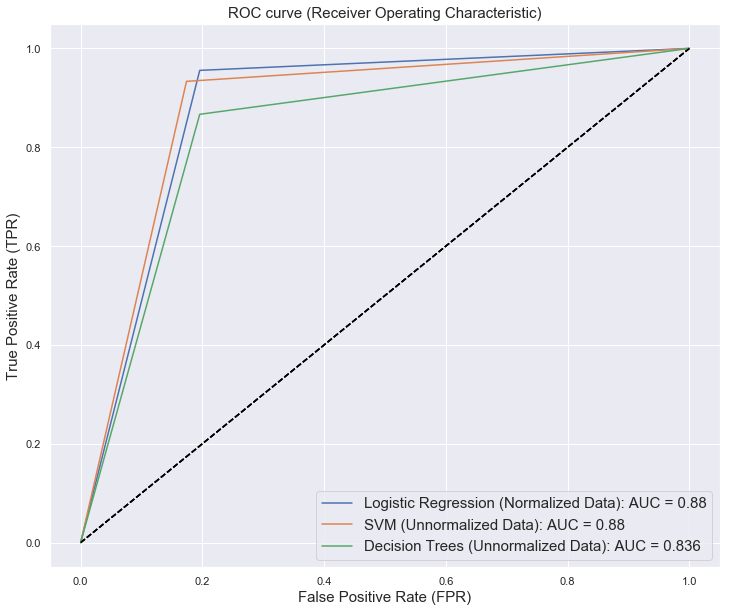

In [90]:
plt.figure(figsize=(12,10))

for test, pred, num, name in zip([y_test, y_test, y_test], [y_pred_lr_nm,y_pred_svm,y_pred_dt], range(1,4), ['Logistic Regression (Normalized Data)', 'SVM (Unnormalized Data)', 'Decision Trees (Unnormalized Data)']):
    fpr, tpr, thresholds = roc_curve(test, pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='{}: AUC = {}'.format(name, round(roc_auc, 3)))
    plt.legend(loc='best')
    plt.plot([0,1],[0,1],color='black', linestyle='--')

plt.title('ROC curve (Receiver Operating Characteristic)', fontsize = '15')    
plt.ylabel('True Positive Rate (TPR)' ,fontsize = '15')
plt.xlabel('False Positive Rate (FPR)', fontsize = '15')
plt.legend(loc=4, prop={'size': 15})


plt.show()